<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>Author: [Yury Kashnitsky](https://yorko.github.io/). Translated and edited by [Serge Oreshkov](https://www.linkedin.com/in/sergeoreshkov/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/).

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center> Topic 8. Vowpal Wabbit: Learning with Gigabytes of Data
This week, we’ll cover two reasons for Vowpal Wabbit’s exceptional training speed, namely, online learning and hashing trick, in both theory and practice. We will try it out with news, movie reviews, and StackOverflow questions.

# Outline
1. Stochastic gradient descent and online learning
    - 1.1. SGD
    - 1.2. Online approach to learning
2. Categorical data processing: Label Encoding, One-Hot Encoding, Hashing trick
    - 2.1. Label Encoding
    - 2.2. One-Hot Encoding
    - 2.3. Hashing trick
3. Vowpal Wabbit
    - 3.1. News. Binary classification
    - 3.2. News. Multiclass classification
    - 3.3. IMDB reviews
    - 3.4. Classifying gigabytes of StackOverflow questions
4. VW and Spooky Author Identification 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. Stochastic gradient descent and online learning
##  1.1. Stochastic gradient descent

Despite the fact that gradient descent is one of the first things learned in machine learning and optimization courses, it is one of its modifications, Stochastic Gradient Descent (SGD), that is hard to top.

Recall that the idea of gradient descent is to minimize some function by making small steps in the direction of the fastest decrease. This method was named due to the following fact from calculus: vector $\nabla f = (\frac{\partial f}{\partial x_1}, \ldots \frac{\partial f}{\partial x_n})^\text{T}$ of partial derivatives of the function $f(x) = f(x_1, \ldots x_n)$ points to the direction of the fastest function growth. It means that, by moving in the opposite direction (antigradient), it is possible to decrease the function value with the fastest rate.

<img src='https://habrastorage.org/files/4f2/75d/a46/4f275da467a44fc4a8d1a11007776ed2.jpg' width=70%>

Here is a snowboarder (me) in Sheregesh, Russia's most popular winter resort. (I highly recommended it if you like skiing or snowboarding). In addition to advertising the beautiful landscapes, this picture depicts the idea of gradient descent. If you want to ride as fast as possible, you need to choose the path of steepest descent. Calculating antigradients can be seen as evaluating the slope at various spots.

**Example**

The paired regression problem can be solved with gradient descent. Let us predict one variable using another: height with weight. Assume that these variables are linearly dependent. We will use the [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data) dataset. 

In [2]:
PATH_TO_ALL_DATA = '../../data/'
data_demo = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                     'weights_heights.csv'))

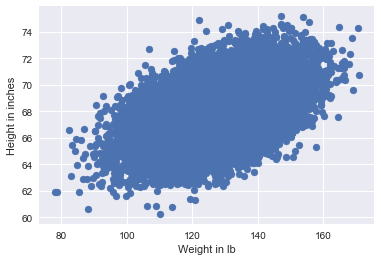

In [3]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Weight in lb')
plt.ylabel('Height in inches');

Here we have a vector $x$ of dimension $\ell$ (weight of every person i.e. training sample) and $y$, a vector containing the height of every person in the dataset. 

The task is the following: find weights $w_0$ and $w_1$ such that predicting height as $y_i = w_0 + w_1 x_i$ (where $y_i$ is $i$-th height value, $x_i$ is $i$-th weight value) minimizes the squared error (as well as mean squared error since $\frac{1}{\ell}$ doesn't make any difference ):
$$SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^\ell(y_i - (w_0 + w_1x_{i}))^2 \rightarrow min_{w_0,w_1}$$

We will use gradient descent, utilizing the partial derivatives of $SE(w_0, w_1)$ over weights $w_0$ and $w_1$.
An iterative training procedure is then defined by simple update formulas (we change model weights in small steps, proportional to a small constant $\eta$, towards the antigradient of the function $SE(w_0, w_1)$):

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} -\eta \frac{\partial SE}{\partial w_0} |_{t} \\  w_1^{(t+1)} = w_1^{(t)} -\eta \frac{\partial SE}{\partial w_1} |_{t} \end{array}$$

Computing the partial derivatives, we get the following: 

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

This math works quite well as long as the amount of data is not large (we will not discuss issues with local minima, saddle points, choosing the learning rate, moments and other stuff –- these topics are covered very thoroughly in [the Numeric Computation chapter](http://www.deeplearningbook.org/contents/numerical.html) in "Deep Learning"). 
There is an issue with batch gradient descent -- the gradient evaluation requires the summation of a number of values for every object from the training set. In other words, the algorithm requires a lot of iterations, and every iteration recomputes weights with formula which contains a sum $\sum_{i=1}^\ell$ over the whole training set. What happens when we have billions of training samples?

<img src="https://habrastorage.org/webt/ow/ng/cs/owngcs-lzoguklv1pn9vz_r4ssm.jpeg" />

Hence the motivation for stochastic gradient descent! Simply put, we throw away the summation sign and update the weights only over single training samples (or a small number of them). In our case, we have the following:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

With this approach, there is no guarantee that we will move in best possible direction at every iteration. Therefore, we may need many more iterations, but we get much faster weight updates.

Andrew Ng has a good illustration of this in his [machine learning course](https://www.coursera.org/learn/machine-learning). Let's take a look.

<img src='https://habrastorage.org/files/f8d/90c/f83/f8d90cf83b044255bb07df3373f25fc7.png'>

These are the contour plots for some function, and we want to find the global minimum of this function. The red curve shows weight changes (in this picture, $\theta_0$ and $\theta_1$ correspond to our $w_0$ and $w_1$). According to the properties of a gradient, the direction of change at every point is orthogonal to contour plots. With stochastic gradient descent, weights are changing in a less predictable manner, and it even may seem that some steps are wrong by leading away from minima; however, both procedures converge to the same solution.

## 1.2. Online approach to learning
Stochastic gradient descent gives us practical guidance for training both classifiers and regressors with large amounts of data up to hundreds of GBs (depending on computational resources).

Considering the case of paired regression, we can store the training data set $(X,y)$ in HDD without loading it into RAM (where it simply won't fit), read objects one by one, and update the weights of our model:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

After working through the whole training dataset, our loss function (for example, quadratic squared root error in regression or logistic loss in classification) will decrease, but it usually takes dozens of passes over the training set to make the loss small enough. 

This approach to learning is called **online learning**, and this name emerged even before machine learning MOOC-s turned mainstream.

We did not discuss many specifics about SGD here. If you want dive into theory, I highly recommend ["Convex Optimization" by Stephen Boyd](https://www.amazon.com/Convex-Optimization-Stephen-Boyd/dp/0521833787). Now, we will introduce the Vowpal Wabbit library, which is good for training simple models with huge data sets thanks to stochastic optimization and another trick, feature hashing.

In scikit-learn, classifiers and regressors trained with SGD are named  `SGDClassifier` and `SGDRegressor` in `sklearn.linear_model`. These are nice implementations of SGD, but we'll focus on VW since it is more performant than sklearn's SGD models in many aspects.

# 2. Categorical feature processing: Label Encoding, One-Hot Encoding, and Hashing trick

## 2.1. Label Encoding
Many classification and regression algorithms operate in Euclidean or metric space, implying that data is represented with vectors of real numbers. However, in real data, we often have categorical features with discrete values such as yes/no or January/February/.../December. We will see how to process this kind of data, particularly with linear models, and how to deal with many categorial features even when they have many unique values.

Let's explore the [UCI bank marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) where most of  features are categorial.

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, 'bank_train.csv'))
labels = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                  'bank_train_target.csv'), 
                     header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


We can see that most of features are not represented by numbers. This poses a problem because we cannot use most machine learning methods (at least those implemented in scikit-learn) out-of-the-box.

Let's dive into the "education" feature.

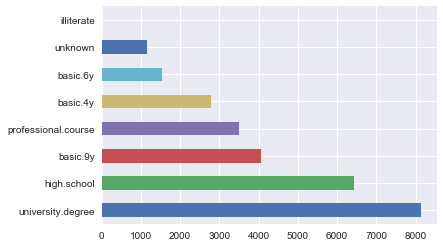

In [5]:
df['education'].value_counts().plot.barh();

The most straightforward solution is to map each value of this feature into a unique number. For example, we can map  `university.degree` to 0, `basic.9y` to 1, and so on. You can use `sklearn.preprocessing.LabelEncoder` to perform this mapping.

In [6]:
label_encoder = LabelEncoder()

The `fit` method of this class finds all unique values and builds the actual mapping between categories and numbers, and the `transform` method  converts the categories into numbers. After `fit` is executed, `label_encoder` will have the `classes_` attribute with all unique values of the feature. Let us count them to make sure the transformation was correct.

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


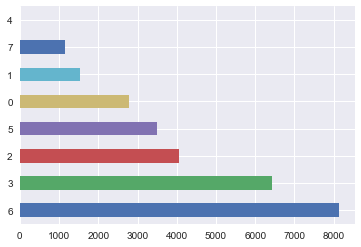

In [7]:
mapped_education = pd.Series(label_encoder.fit_transform(
    df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [8]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Let's apply the transformation to other columns of type `object`.

In [9]:
categorical_columns = df.columns[df.dtypes 
                                 == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


The main issue with this approach is that we have now introduced some relative ordering where it might not exist.  

For example, we implicitly introduced algebra over the values of the job feature where we can now substract the job of client #2 from the job of client #1 :

In [10]:
df.loc[1].job - df.loc[2].job

-1.0

Does this operation make any sense? Not really. Let's try to train logisitic regression with this feature transformation.

In [11]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = \
        train_test_split(features, labels)

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, 
                                 logit.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], 
                                      labels))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94      6104
          1       0.50      0.00      0.00       795

avg / total       0.84      0.88      0.83      6899



We can see that logistic regression never predicts class 1. In order to use linear models with categorial features, we will use a different approach: One-Hot Encoding.

## 2.2. One-Hot Encoding

Suppose that some feature can have one of 10 unique values. One-hot encoding creates 10 new features corresponding to these unique values, all of them *except one* are zeros.

In [12]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


This idea is implemented in the `OneHotEncoder` class from `sklearn.preprocessing`. By default `OneHotEncoder` transforms data into a sparse matrix to save memory space because most of the values are zeroes and because we do not want to take up more RAM. However, in this particular example, we do not encounter such problems, so we are going to use a "dense" matrix representation.

In [13]:
onehot_encoder = OneHotEncoder(sparse=False)

In [14]:
encoded_categorical_columns = \
pd.DataFrame(onehot_encoder.fit_transform(
    df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We have 53 columns that correspond to the number of unique values of categorical features in our data set. When transformed with One-Hot Encoding, this data can be used with linear models:

In [15]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      6102
          1       0.67      0.18      0.29       797

avg / total       0.88      0.90      0.87      6899



## 2.3. Hashing trick
Real data can be volatile, meaning we cannot guarantee that new values of categorial features will not occur. This issue hampers using a trained model on new data. Besides that, `LabelEncoder` requires preliminary analysis of the whole dataset and storage of constructed mappings in memory, which makes it difficult to work with large datasets.

There is a simple approach to vectorization of categorial data based on hashing and is known as, not-so-surprisingly, the hashing trick. 

Hash functions can help us find unique codes for different feature values, for example:

In [16]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> -6241459093488141593
high.school -> 7728198035707179500
illiterate -> -7360093633803373451


We will not use negative values or values of high magnitude, so we restrict the range of values for the hash function:

In [17]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 7
high.school -> 0
illiterate -> 24


Imagine that our data set contains a single (i.e. not married) student, who received a call on Monday. His feature vectors will be created similarly as in the case of One-Hot Encoding but in the space with fixed range for all features:

In [18]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 20
marital=single -> 23
day_of_week=mon -> 9


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


We want to point out that we hash not only feature values but also pairs of **feature name + feature value**. It is important to do this so that we can distinguish the same values of different features.

In [19]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Is it possible to have a collision when using hash codes? Sure, it is possible, but it is a rare case with large enough hashing spaces. Even if collision occurs, regression or classification metrics will not suffer much. In this case, hash collisions work as a form of regularization.

<img src="https://habrastorage.org/webt/4o/wx/59/4owx59vdvwc9mzrf81t2fa2rqrc.jpeg">

You may be saying "WTF?"; hashing seems counterintuitive. This is true, but these heuristics sometimes are, in fact, the only plausible approach to work with categorial data. Moreover, this technique has proven to just work. As you work more with data, you may see this for yourself.

# 3. Vowpal Wabbit

[Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit) (VW) is one of the most widespread machine learning libraries used in industry. It is prominent for its training speed and support of many training modes, especially for online learning with big and high-dimentional data. This is one of the major merits of the library. Also, with the hashing trick implemented, Vowpal Wabbit is a perfect choice for working with text data.

Shell is the main interface for VW.

In [20]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all 

Vowpal Wabbit reads data from files or from standard input stream (stdin) with the following format:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

here [] denotes non-mandatory elements, and (...)\* means multiple inputs allowed. 

- **Label** is a number. In the case of classification, it is usually 1 and -1; for regression, it is a real float value
- **Importance** is a number. It denotes the sample weight during training. Setting this helps when working with imbalanced data.
- **Tag** is a string without spaces. It is the "name" of the sample that VW saves upon prediction. In order to separate Tag from Importance, it is better to start Tag with the ' character.
- **Namespace** is for creating different feature spaces. 
- **Features** are object features inside a given **Namespace**. Features have weight 1.0 by default, but it can be changed, for example feature:0.1. 


The following string matches the VW format:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


Let's check the format by running VW with this training sample:

In [21]:
! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 1.000000
average loss = 1.000000
best constant = 1.000000
best constant's loss = 0.000000
total feature number = 10


VW is a wonderful tool for working with text data. We'll illustrate it with the [20newsgroups dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html), which contains letters from 20 different newsletters.


## 3.1. News. Binary classification.

In [22]:
# load data with sklearn's function 
newsgroups = fetch_20newsgroups(PATH_TO_ALL_DATA)

In [23]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Lets look at the first document in this collection:

In [24]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Now we convert the data into something Vowpal Wabbit can understand. We will throw away words shorter than 3 symbols. Here, we will skip some important NLP stages such as stemming and lemmatization; however, we will later see that VW solves the problem even without these steps.

In [25]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', 
                                               document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

We split the dataset into train and test and write these into separate files. We will consider a document as positive if it corresponds to **rec.autos**. Thus, we are constructing a model which distinguishes articles about cars from other topics: 

In [26]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [27]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with open(os.path.join(PATH_TO_ALL_DATA, '20news_train.vw'), 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_ALL_DATA, '20news_test.vw'), 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Now, we pass the created training file to Vowpal Wabbit. We solve the classification problem with a hinge loss function (linear SVM). The trained model will be saved in the `20news_model.vw` file:

In [28]:
!vw -d $PATH_TO_ALL_DATA/20news_train.vw \
 --loss_function hinge -f $PATH_TO_ALL_DATA/20news_model.vw

final_regressor = ../../data//20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000  -0.6425       44
0.21

VW prints a lot of interesting info while training (one can suppress it with the `--quiet` parameter). You can see documentation of the diagnostic output on [GitHub](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial#vws-diagnostic-information). Note how average loss drops while training. For loss computation, VW uses samples it has never seen before, so this measure is usually accurate. Now, we apply our trained model to the test set, saving predictions into a file with the `-p` flag:  

In [29]:
!vw -i $PATH_TO_ALL_DATA/20news_model.vw -t -d $PATH_TO_ALL_DATA/20news_test.vw \
-p $PATH_TO_ALL_DATA/20news_test_predictions.txt

only testing
predictions = ../../data//20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000      349
    n.a.     n.a.            2            2.0  unknown  -1.0000       50
    n.a.     n.a.            4            4.0  unknown  -1.0000      251
    n.a.     n.a.            8            8.0  unknown  -1.0000      237
    n.a.     n.a.           16           16.0  unknown  -0.8978      106
    n.a.     n.a.           32           32.0  unknown  -1.0000      964
    n.a.     n.a.           64           64.0  unknown  -1.0000      261
    n.a.     n.a.          128          128.0  unknown   0.4621       82
    n.a.     n.a.          256          256.0  unknown  -

Now we load our predictions, compute AUC, and plot the ROC curve:

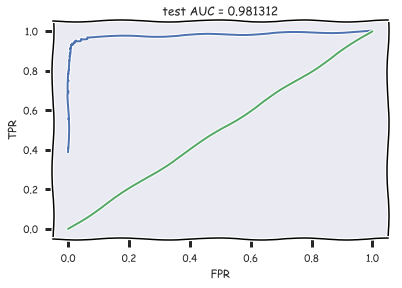

In [30]:
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_test_predictions.txt')) as pred_file:
    test_prediction = [float(label) 
                       for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); 
    plt.title('test AUC = %f' % (auc)); 
    plt.axis([-0.05,1.05,-0.05,1.05]);

The AUC value we get shows that we have achieved high classification quality.

# 3.2. News. Multiclass classification

We will use the same news dataset, but, this time, we will solve a multiclass classification problem. `Vowpal Wabbit` is a little picky – it wants labels starting from 1 till K, where K – is the number of classes in the classification task (20 in our case). So we will use LabelEncoder and add 1 afterwards (recall that `LabelEncoder` maps labels into range from 0 to K-1).

In [31]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**The data is the same, but we have changed the labels, train_labels_mult and test_labels_mult, into label vectors from 1 to 20.**

In [32]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)
    
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_train_mult.vw'), 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_test_mult.vw'), 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

We train Vowpal Wabbit in multiclass classification mode, passing the `oaa` parameter("one against all") with the number of classes. Also, let's see what parameters our model quality is dependent on (more info can be found in the [official Vowpal Wabbit tutorial](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)):
 - learning rate (-l, 0.5 default) – rate of weight change on every step
 - learning rate decay (--power_t, 0.5 default) – it is proven in practice, that, if the learning rate drops with the number of steps in stochastic gradient descent, we approach the minimum loss better
 - loss function (--loss_function) – the entire training algorithm depends on it. See [docs](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions) for loss functions
 - Regularization (-l1) – note that VW  calculates regularization for every object. That is why we usually set regularization values to about $10^{-20}.$
 
Additionally, we can try automatic Vowpal Wabbit parameter tuning with [Hyperopt](https://github.com/hyperopt/hyperopt).

In [33]:
%%time
!vw --oaa 20 $PATH_TO_ALL_DATA/20news_train_mult.vw -f $PATH_TO_ALL_DATA/20news_model_mult.vw \
--loss_function=hinge

final_regressor = ../../data//20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       15        1      157
1.000000 1.000000            2            2.0        2       15      159
1.000000 1.000000            4            4.0       15       10       92
1.000000 1.000000            8            8.0       16       15      129
1.000000 1.000000           16           16.0       13       12      108
0.937500 0.875000           32           32.0        2        9      115
0.906250 0.875000           64           64.0       16       16      114
0.867188 0.828125          128          128.0        8        4      110
0.816406 0.765625          256          256.0        7       15    

In [34]:
%%time
!vw -i $PATH_TO_ALL_DATA/20news_model_mult.vw -t -d $PATH_TO_ALL_DATA/20news_test_mult.vw \
-p $PATH_TO_ALL_DATA/20news_test_predictions_mult.txt

only testing
predictions = ../../data//20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data//20news_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown        8      349
    n.a.     n.a.            2            2.0  unknown        6       50
    n.a.     n.a.            4            4.0  unknown       18      251
    n.a.     n.a.            8            8.0  unknown       18      237
    n.a.     n.a.           16           16.0  unknown        4      106
    n.a.     n.a.           32           32.0  unknown       15      964
    n.a.     n.a.           64           64.0  unknown        4      261
    n.a.     n.a.          128          128.0  unknown        8       82
    n.a.     n.a.          256          256.0  

In [35]:
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_test_predictions_mult.txt')) as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [36]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

Here is how often the model misclassifies atheism with other topics:

In [37]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0,i])

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 3
talk.religion.misc 5


# 3.3. IMDB movie reviews
In this part we will do binary classification of [IMDB](http://www.imdb.com) (International Movie DataBase) movie reviews. We will see how fast Vowpal Wabbit performs.

Using the `load_files` function from `sklearn.datasets`, we load the movie reviews [here](https://drive.google.com/file/d/1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l/view?usp=sharing). If you want to reproduce the results, please download the archive, unzip it, and set the path to `imdb_reviews` (it already contains *train* and *test* subdirectories). Unpacking can take several minutes as there are 100k files. Both train and test sets hold 12.5k good and bad movie reviews. First, we split the texts and labels.

In [39]:
import pickle

In [41]:
# change this for your path to imdb_reviews
path_to_movies = os.path.expanduser('/Users/y.kashnitsky/Documents/Machine_learning/datasets/imdb_reviews')
reviews_train = load_files(os.path.join(path_to_movies, 'train'))
text_train, y_train = reviews_train.data, reviews_train.target

In [42]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


Do the same for the test set.

In [43]:
reviews_test = load_files(os.path.join(path_to_movies, 'test'))
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


Take a look at examples of reviews and their corresponding labels.

In [44]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [45]:
y_train[0] # good review

1

In [46]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [47]:
y_train[1] # bad review

0

In [48]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

Now, we prepare training (`movie_reviews_train.vw`), validation (`movie_reviews_valid.vw`), and test (`movie_reviews_test.vw`) sets for Vowpal Wabbit. We will use 70% for training, 30% for the hold-out set.

In [49]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [50]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [54]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_reviews_train.vw'), 'w') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_reviews_valid.vw'), 'w') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_reviews_test.vw'), 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [55]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_train.vw

1 |text zero day leads you think even think why two boys young men would what they did commit mutual suicide via slaughtering their classmates captures what must beyond bizarre mode being for two humans who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time the filmmaker and actors had remarkable product terms explaining the motives and actions the two young suicide murderers better than elephant terms being film that gets under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty
-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regardi

In [56]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [57]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Now, launch Vowpal Wabbit with the following arguments:**

 - -d, path to training set (corresponding .vw file)
 - --loss_function – hinge (feel free to experiment here)
 - -f – path to the output file (which can also be in the .vw format)

In [58]:
!vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw --loss_function hinge \
-f $PATH_TO_ALL_DATA/movie_reviews_model.vw --quiet

Next, make the hold-out prediction with the following VW arguments:
 - -i –path to the trained model (.vw file)
 - -t -d – path to hold-out set (.vw file) 
 - -p – path to a txt-file where the predictions will be stored

In [59]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
-d $PATH_TO_ALL_DATA/movie_reviews_valid.vw -p $PATH_TO_ALL_DATA/movie_valid_pred.txt --quiet

Read the predictions from the text file and estimate the accuracy and ROC AUC. Note that VW prints probability estimates of the +1 class. These estimates are distributed from  -1 to 1, so we can convert these into binary answers, assuming that positive values belong to class 1.

In [60]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_valid_pred.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


Again, do the same for the test set.

In [62]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
-d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
-p $PATH_TO_ALL_DATA/movie_test_pred.txt --quiet

In [63]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_test_pred.txt')) as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


Let's try to achieve a higher accuracy by incorporating bigrams.

In [64]:
!vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f $PATH_TO_ALL_DATA/movie_reviews_model2.vw --quiet

In [66]:
!vw -i$PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_valid.vw \
-p $PATH_TO_ALL_DATA/movie_valid_pred2.txt --quiet

In [67]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_valid_pred2.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [68]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
-p $PATH_TO_ALL_DATA/movie_test_pred2.txt --quiet

In [69]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_test_pred2.txt')) as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


Adding bigrams really helped to improve our model!

# 3.4. Classifying gigabytes of StackOverflow questions

Now, let's see Vowpal Wabbit work on large datasets. There is a 10GB dataset of StackOverflow questions [here](https://drive.google.com/file/d/1ZU4J3KhJDrHVMj48fROFcTsTZKorPGlG/view?usp=sharing). The original dataset is comprised of 10 million questions; each question can have several tags. The data is quite clean, so don't call it "Big Data", even in a pub. :)

<img src='https://habrastorage.org/files/94f/314/7e1/94f3147e107c45dc80a42d29cf6d0e6e.jpg' width=50%>

We chose only 10 tags: 'javascript', 'java', 'python', 'ruby', 'php', 'c++', 'c#', 'go', 'scala' and 'swift'. Let's solve the 10-class classification problem: we want to predict a tag corresponding to one of these 10 popular programming languages given only the text of the question.

In [70]:
# change the path to data
PATH_TO_STACKOVERFLOW_DATA = '/Users/y.kashnitsky/Documents/stackoverflow_10mln/'

Print the first 3 lines from a sample of the dataset.

In [73]:
!head -3 $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_train.vw

1 | i ve got some code in window scroll that checks if an element is visible then triggers another function however only the first section of code is firing both bits of code work in and of themselves if i swap their order whichever is on top fires correctly my code is as follows fn isonscreen function use strict var win window viewport top win scrolltop left win scrollleft bounds this offset viewport right viewport left + win width viewport bottom viewport top + win height bounds right bounds left + this outerwidth bounds bottom bounds top + this outerheight return viewport right lt bounds left viewport left gt bounds right viewport bottom lt bounds top viewport top gt bounds bottom window scroll function use strict var load_more_results ajax load_more_results isonscreen if load_more_results true loadmoreresults var load_more_staff ajax load_more_staff isonscreen if load_more_staff true loadmorestaff what am i doing wrong can you only fire one event from window scroll i assume not
4 |

After selecting our 10 tags, we have a 4.7G dataset that we divide into train and test.

In [74]:
!du -hs $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_*.vw

4,7G	/Users/y.kashnitsky/Documents/stackoverflow_10mln//stackoverflow_10mln.vw
1,6G	/Users/y.kashnitsky/Documents/stackoverflow_10mln//stackoverflow_test.vw
3,1G	/Users/y.kashnitsky/Documents/stackoverflow_10mln//stackoverflow_train.vw


We will process the training set (3.1 GiB) with Vowpal Wabbit and the following arguments: 
- -oaa 10 – for multiclass classification with 10 classes
- -d – path to data
- -f – path to output file of the trained model
- -b 28 – we will use 28 bits for hashing, resulting in a $2^{28}$-sized feature space
- fix random seed for reproducibility

In [75]:
%%time
!vw --oaa 10 -d $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_train.vw \
-f vw_model1_10mln.vw -b 28 --random_seed 17 --quiet

CPU times: user 559 ms, sys: 171 ms, total: 730 ms
Wall time: 38.5 s


In [76]:
%%time
!vw -t -i vw_model1_10mln.vw -d $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_test.vw \
-p vw_test_pred.csv --random_seed 17 --quiet

CPU times: user 322 ms, sys: 97.4 ms, total: 420 ms
Wall time: 22.8 s


In [77]:
vw_pred = np.loadtxt(os.path.join(PATH_TO_STACKOVERFLOW_DATA, 
                                  'vw_test_pred.csv'))
test_labels = np.loadtxt(os.path.join(PATH_TO_STACKOVERFLOW_DATA, 
                                      'stackoverflow_test_labels.txt'))
accuracy_score(test_labels, vw_pred)

0.91728604842865913

The model has trained and made predictions in less than a minute (check it, these results are reported for a MacBook Pro, mid 2015, 2.2 GHz Intel Core i7, 16GB RAM). Its accuracy is almost 92%. All of this without a Hadoop cluster! :) Impressive, isn't it?


## 4. Useful links
- Official VW [documentation](https://github.com/JohnLangford/vowpal_wabbit/wiki) on Github
- ["Numeric Computation" Chapter](http://www.deeplearningbook.org/contents/numerical.html) of the [Deep Learning book](http://www.deeplearningbook.org/)
- ["Convex Optimization" by Stephen Boyd](https://www.amazon.com/Convex-Optimization-Stephen-Boyd/dp/0521833787)
- "Command-line Tools can be 235x Faster than your Hadoop Cluster" [post](https://aadrake.com/command-line-tools-can-be-235x-faster-than-your-hadoop-cluster.html)
- Benchmarking various ML algorithms on Criteo 1TB dataset on [GitHub](https://github.com/rambler-digital-solutions/criteo-1tb-benchmark)
- [VW on FastML.com](http://fastml.com/blog/categories/vw/)